<a href="https://colab.research.google.com/github/karsarobert/DeepLearning2024/blob/main/11/PTE_DL11_CNN1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with a CNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c09_forecasting_with_cnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras


In [ ]:
temp = pd.read_csv(
    "https://raw.githubusercontent.com/karsarobert/DeepLearning2024/main/temp.csv", sep=';'
    ).values

series = temp

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("idő")
    plt.ylabel("hőmérséklet")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

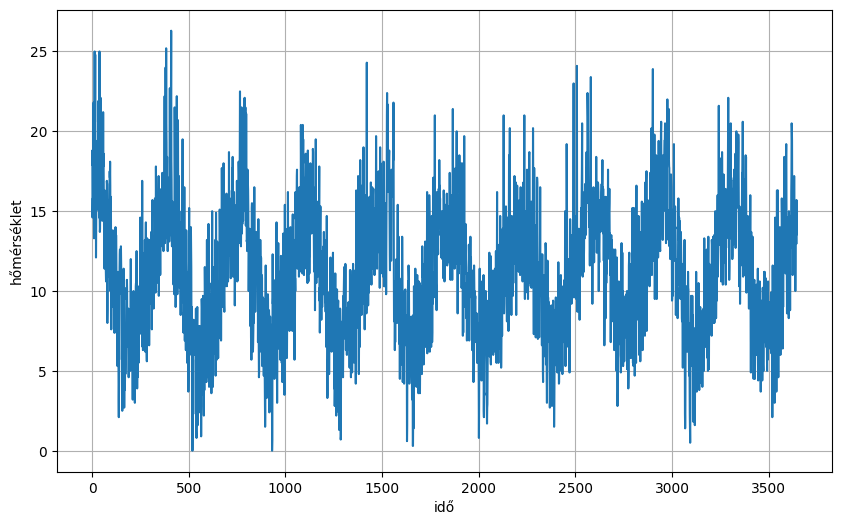

In [ ]:
time = np.arange(len(series))
#time = temp[:,0].astype(np.float32)
series = temp[:,0].astype(np.float32)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [ ]:
split_time = 2000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing With 1D-Convolutional Layers

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True), # a return_sequences=True értéket kell beállítania az LSTM rétegek egymásra halmozásakor
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200) # kimenet méretezése
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 27.1991 - mae: 27.6990 - learning_rate: 1.0000e-08
Epoch 2/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 25.4184 - mae: 25.9183 - learning_rate: 1.1220e-08
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 22.2696 - mae: 22.7694 - learning_rate: 1.2589e-08
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 18.1059 - mae: 18.6056 - learning_rate: 1.4125e-08
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 12.7382 - mae: 13.2367 - learning_rate: 1.5849e-08
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 6.3554 - mae: 6.8455 - learning_rate: 1.7783e-08
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 3.0502 - mae: 3.5205 - learning_rate: 1.9953e-08
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 3.1800 - mae: 3.6538 - learning_rate: 2.2387e-08
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.9432 - mae: 3.4143 - learning_rate: 2.5119e-08
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 2.9223 - mae: 3.3906 - learning_rate: 2.8184e-08
Epoch 11/100
13/13 ━━━

(1e-08, 0.0001, 0.0, 30.0)

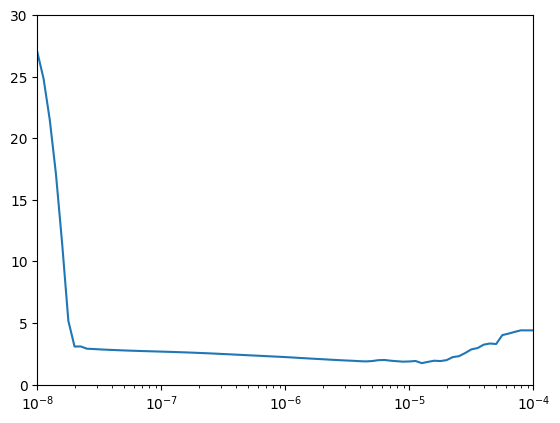

In [ ]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping()
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - loss: 11.5885 - mae: 12.0807 - val_loss: 3.2729 - val_mae: 3.7453
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 4.7471 - mae: 5.2291 - val_loss: 2.7742 - val_mae: 3.2400
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 2.8342 - mae: 3.3016 - val_loss: 1.8970 - val_mae: 2.3500
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 2.1560 - mae: 2.6143 - val_loss: 1.8789 - val_mae: 2.3293
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - loss: 1.9657 - mae: 2.4205 - val_loss: 1.7568 - val_mae: 2.2061
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 1.8806 - mae: 2.3346 - val_loss: 1.6556 - val_mae: 2.0999
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 1.8289 - mae: 2.2828 - val_loss: 1.6233 - val_mae: 2.0679
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 1.8019 - mae: 2.2546 - val_loss: 1.6094 - val_mae: 2.0541
Epoch 9/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step

In [ ]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [ ]:
rnn_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step


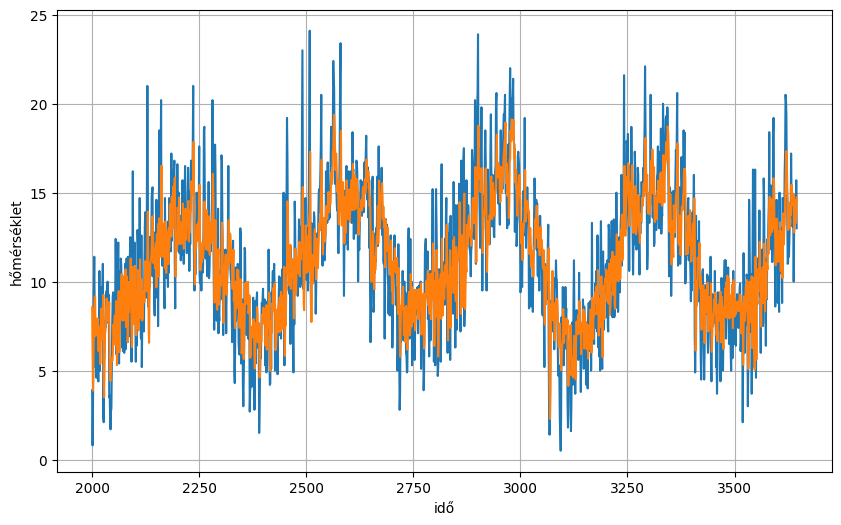

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

1.88919

## Fully Convolutional Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 334ms/step - loss: 9.8335 - mae: 10.3319 - learning_rate: 1.0000e-04
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 9.4138 - mae: 9.9119 - learning_rate: 1.0798e-04
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.7736 - mae: 9.2714 - learning_rate: 1.1659e-04
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.7375 - mae: 8.2333 - learning_rate: 1.2589e-04
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 5.9991 - mae: 6.4894 - learning_rate: 1.3594e-04
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.7528 - mae: 4.2268 - learning_rate: 1.4678e-04
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.2453 - mae: 3.7126 - learning_rate: 1.5849e-04
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.8874 - mae: 3.3514 - learning_rate: 1.7113e-04
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 2.7104 - mae: 3.1712 - learning_rate: 1.8478e-04
Epoch 10/100
13/

(0.0001, 0.1, 0.0, 30.0)

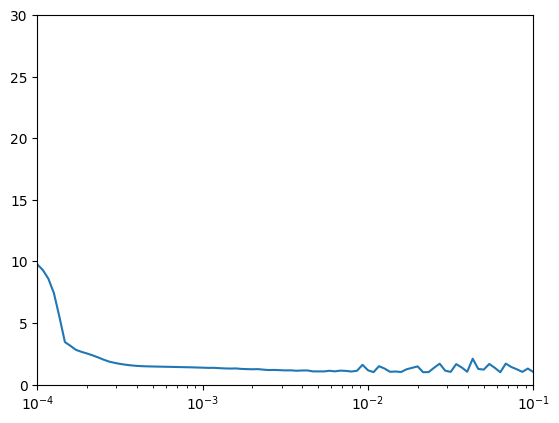

In [ ]:
plt.semilogx(history.history["learning_rate"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 365
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.keras", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 308ms/step - loss: 10.9333 - mae: 11.4331 - val_loss: 11.2282 - val_mae: 11.7282
Epoch 2/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - loss: 10.6794 - mae: 11.1788 - val_loss: 10.9654 - val_mae: 11.4653
Epoch 3/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step - loss: 10.4234 - mae: 10.9223 - val_loss: 10.7133 - val_mae: 11.2131
Epoch 4/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 10.1846 - mae: 10.6834 - val_loss: 10.4345 - val_mae: 10.9342
Epoch 5/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 9.9006 - mae: 10.3992 - val_loss: 10.0745 - val_mae: 10.5741
Epoch 6/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 9.5360 - mae: 10.0342 - val_loss: 9.5884 - val_mae: 10.0876
Epoch 7/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 9.0293 - mae: 9.5272 - val_loss: 8.8973 - val_mae: 9.3955
Epoch 8/500
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - loss: 8.3111 - mae: 8.8086 - val_loss: 7.8907 - val_mae: 8.3889
Epoch 9/500
13/13 ━━━━━━━━━━━━━━

In [ ]:
model = keras.models.load_model("my_checkpoint.keras", safe_mode=False)

In [ ]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step


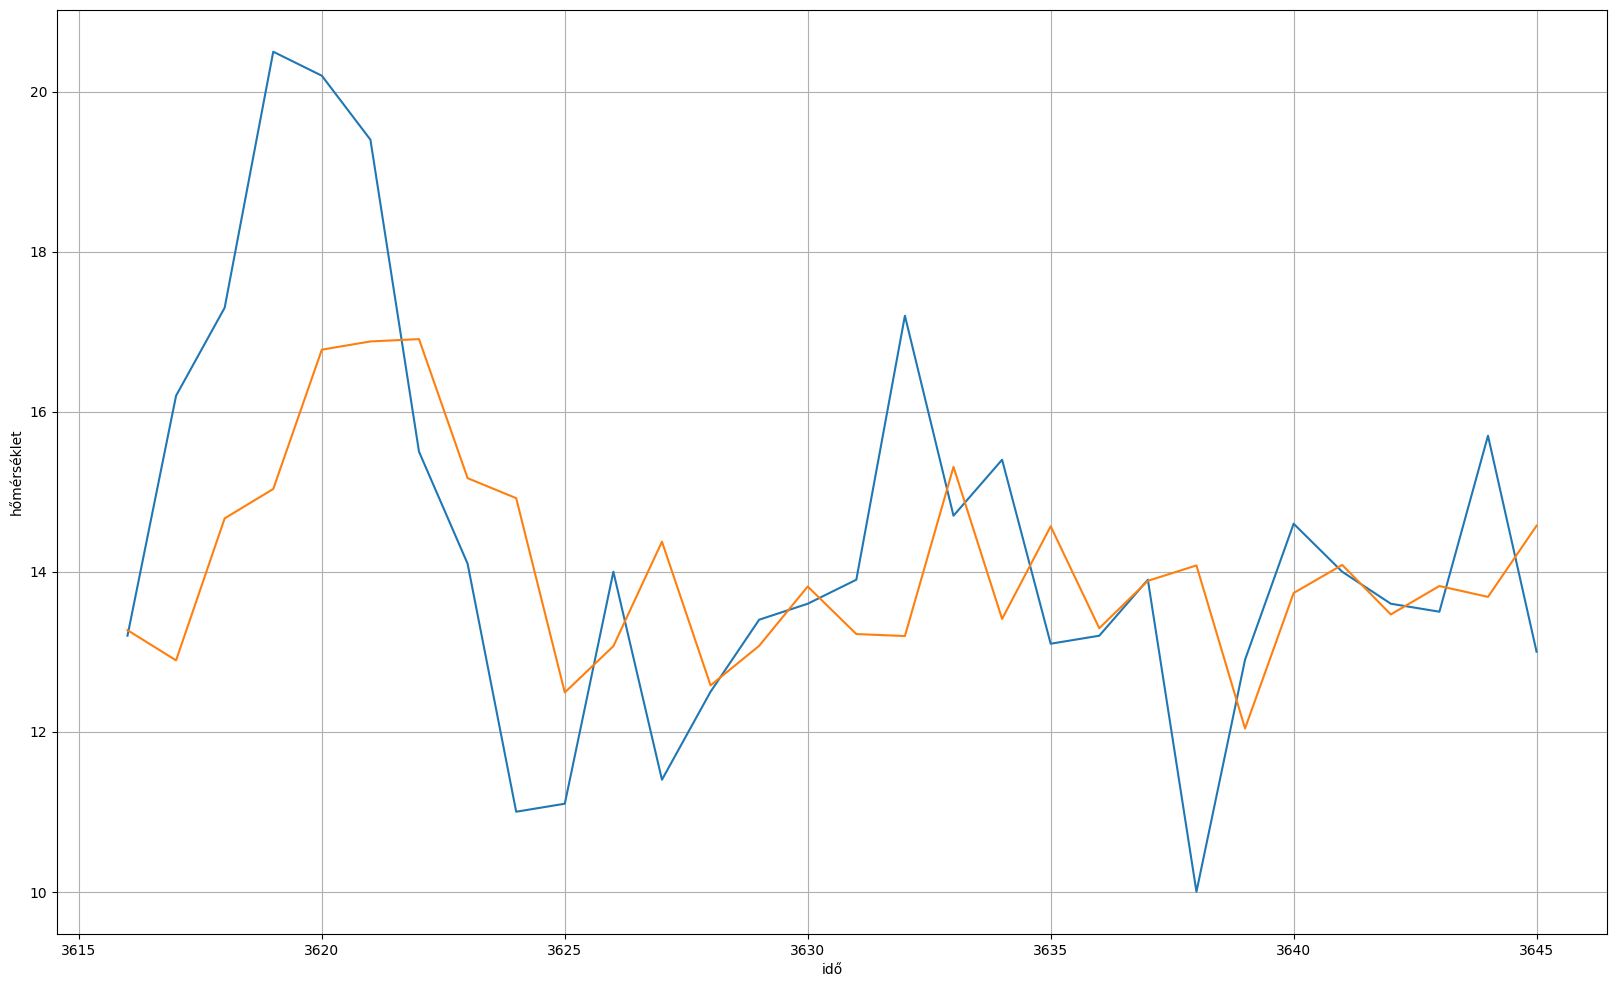

In [ ]:
plt.figure(figsize=(20, 12))
plot_series(time_valid[-30:], x_valid[-30:])
plot_series(time_valid[-30:], cnn_forecast[-30:])

In [ ]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

1.843057